In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
import requests
import aiohttp
import nc_time_axis
import cftime
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_47221/2123990582.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [ ]:
var_df = pd.read_csv("Financial_Support_Agreement_NEW.csv")
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [ ]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='esm-piControl'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190723/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 6000)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0001-01-15 12:00:00 ... 0500-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(813, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  29200.0
    case_id:                973
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 CESM2 esm-piControl experiment with CAM6, i...
    variant_label:          r1i1p1f1
    status:                 2019-11-09;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/4c7e2d6c-fafc-4273-866f-b4a2b73b777a...
    version_id:             v20190723

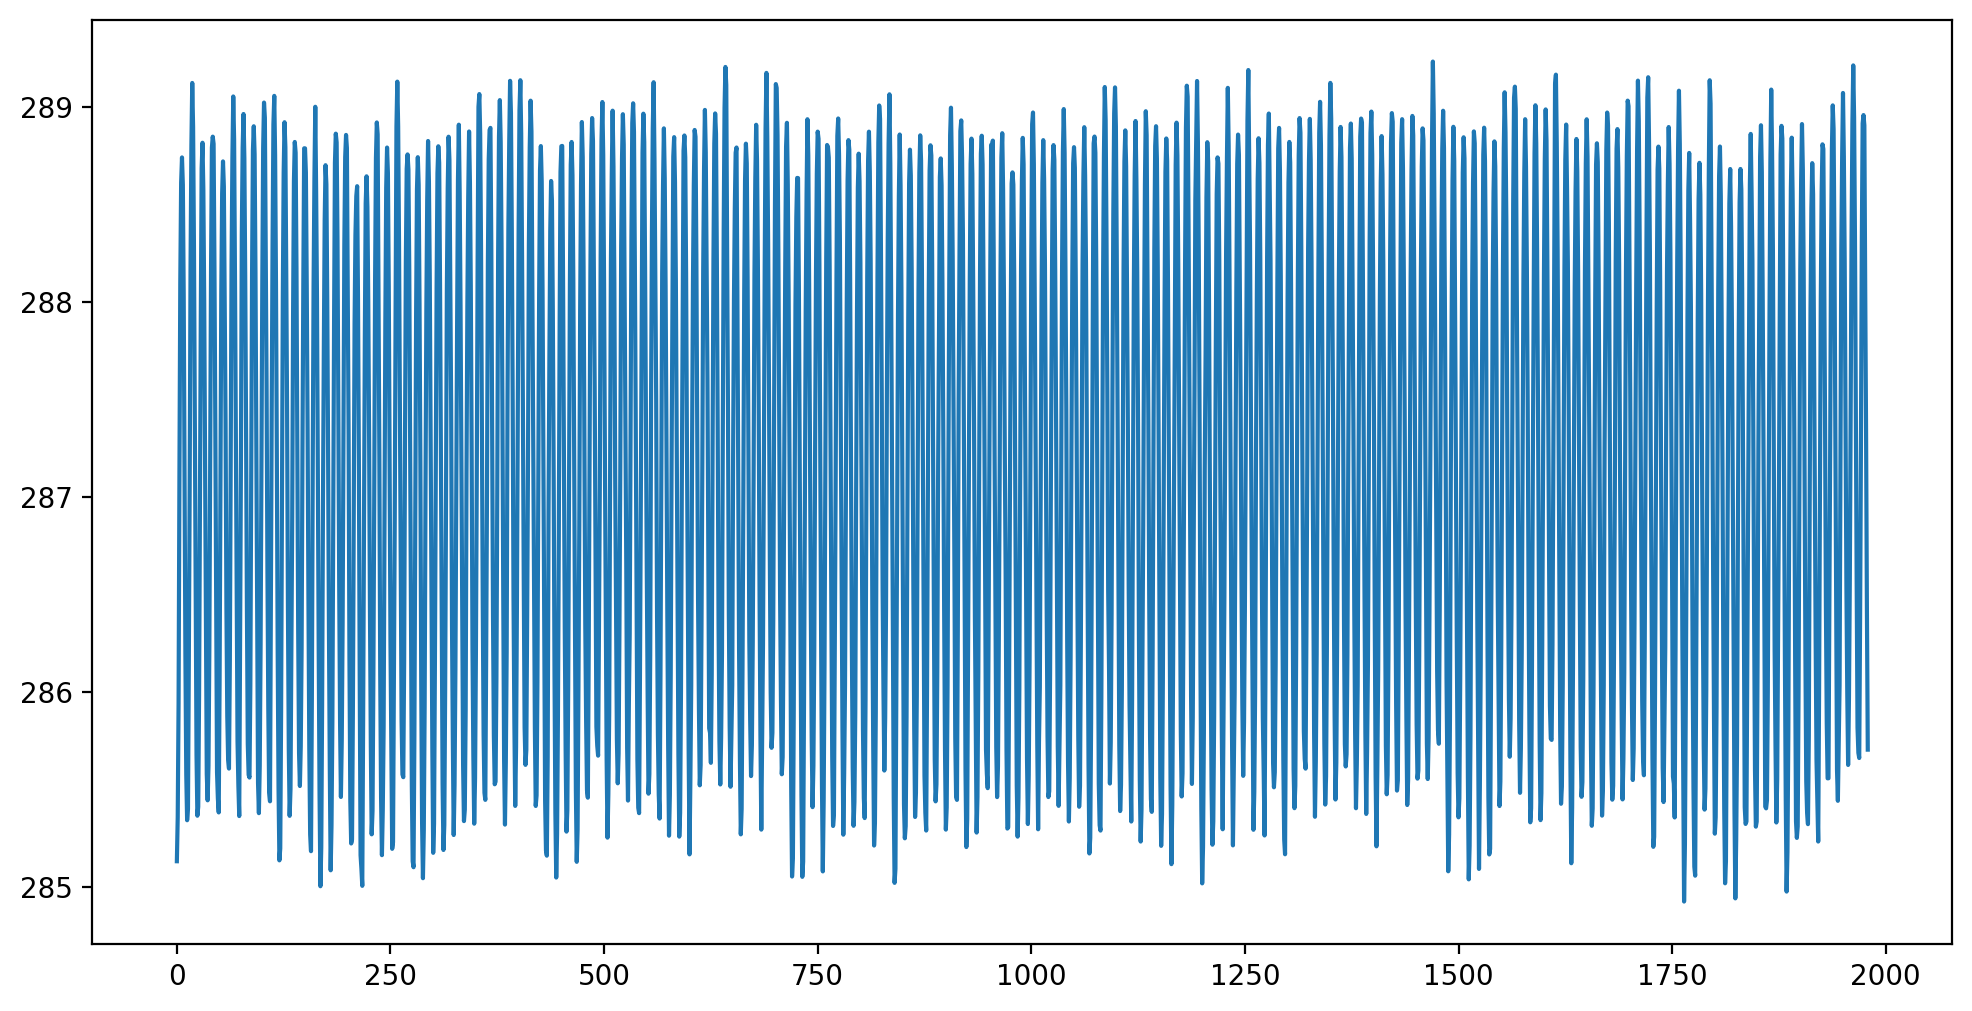

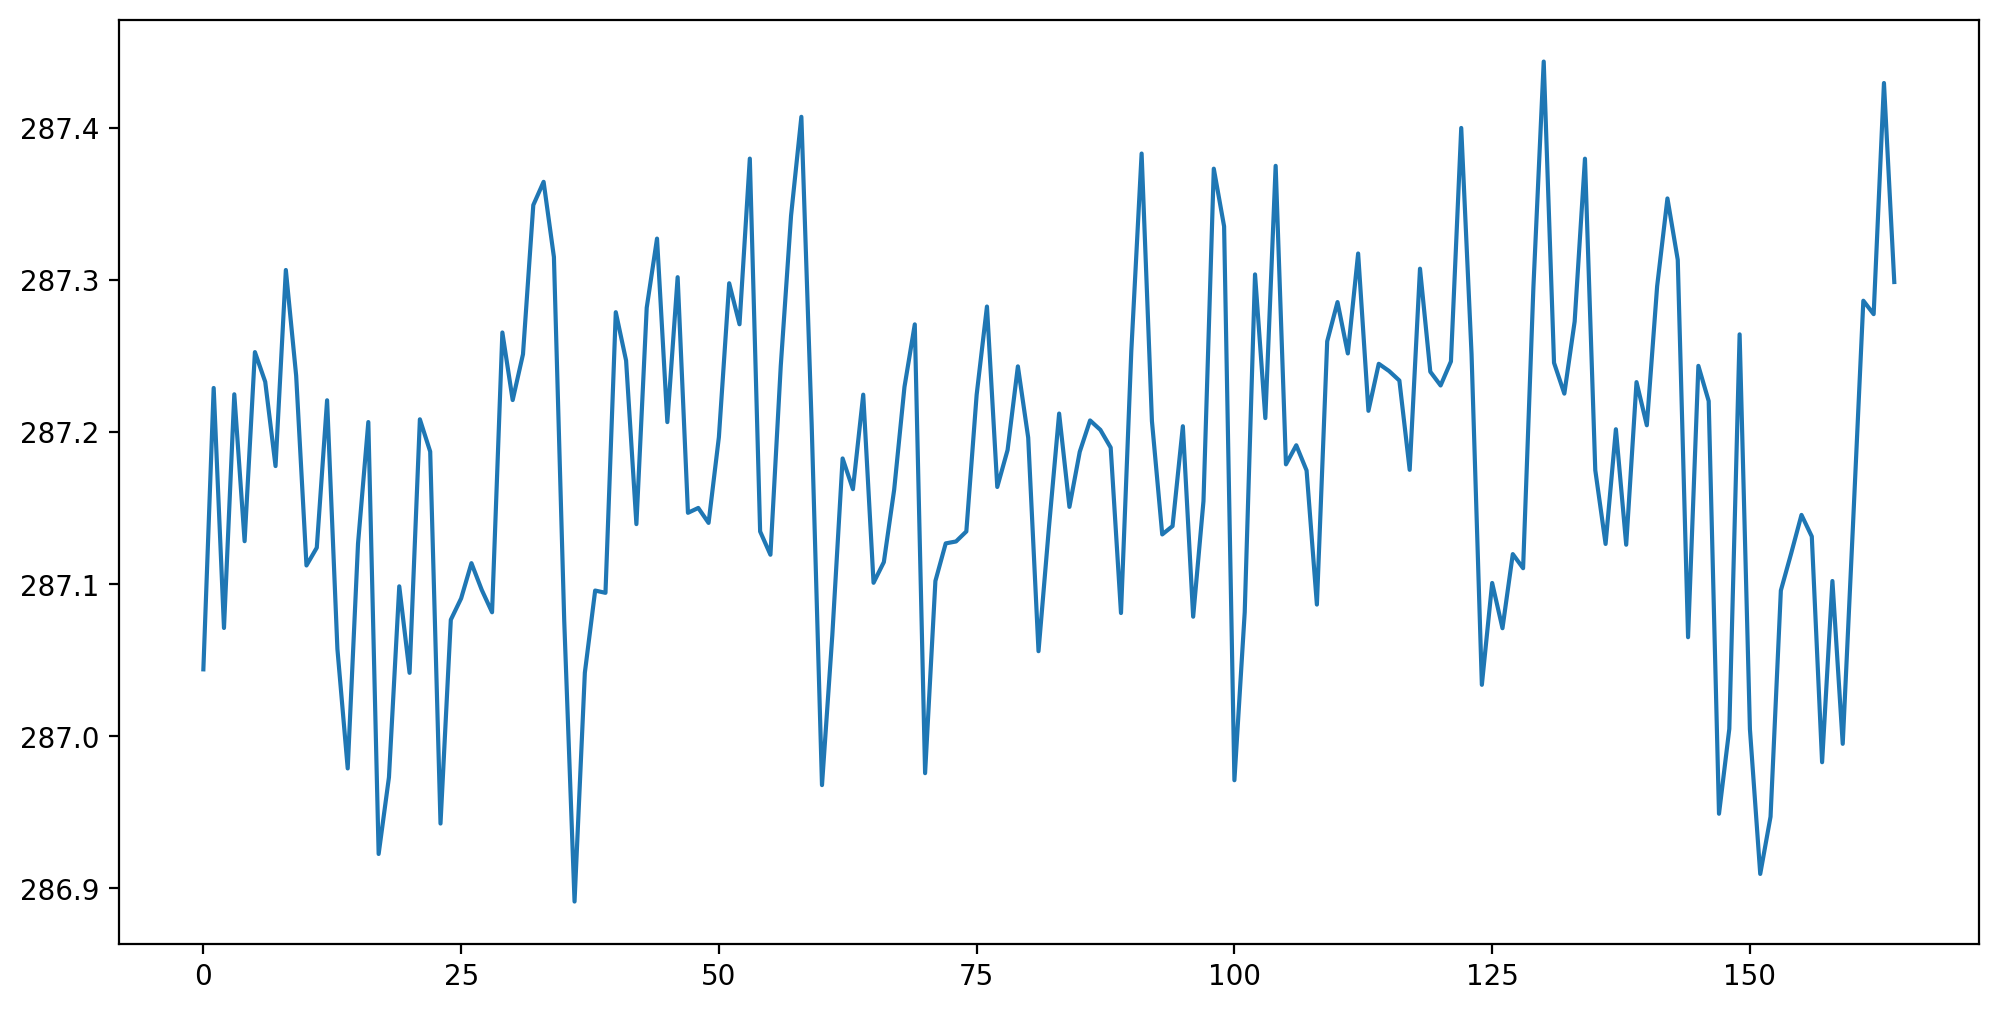

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

df_tas_ncar_piC = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'esm-piControl'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_piC = df_tas_ncar_piC.zstore.values[-1]
print(zstore_piC)

# create a mutable-mapping-style interface to the store
mapper_piC = fsspec.get_mapper(zstore_piC)

# open it using xarray and zarr
ds_tas_piC = xr.open_zarr(mapper_piC, consolidated=True)
display(ds_tas_piC)


date_threshold = cftime.DatetimeNoLeap(166, 1, 1)
ds_tas_piC_plt = ds_tas_piC.where(ds_tas_piC.time < date_threshold, drop=True)
# weighted product
tas_timeseries_piC = (ds_tas_piC_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# convert to np array
array_tas_ts = np.array(tas_timeseries_piC)
plt.plot(array_tas_ts)
plt.show()
year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
plt.plot(year_tas_ts)
plt.show()

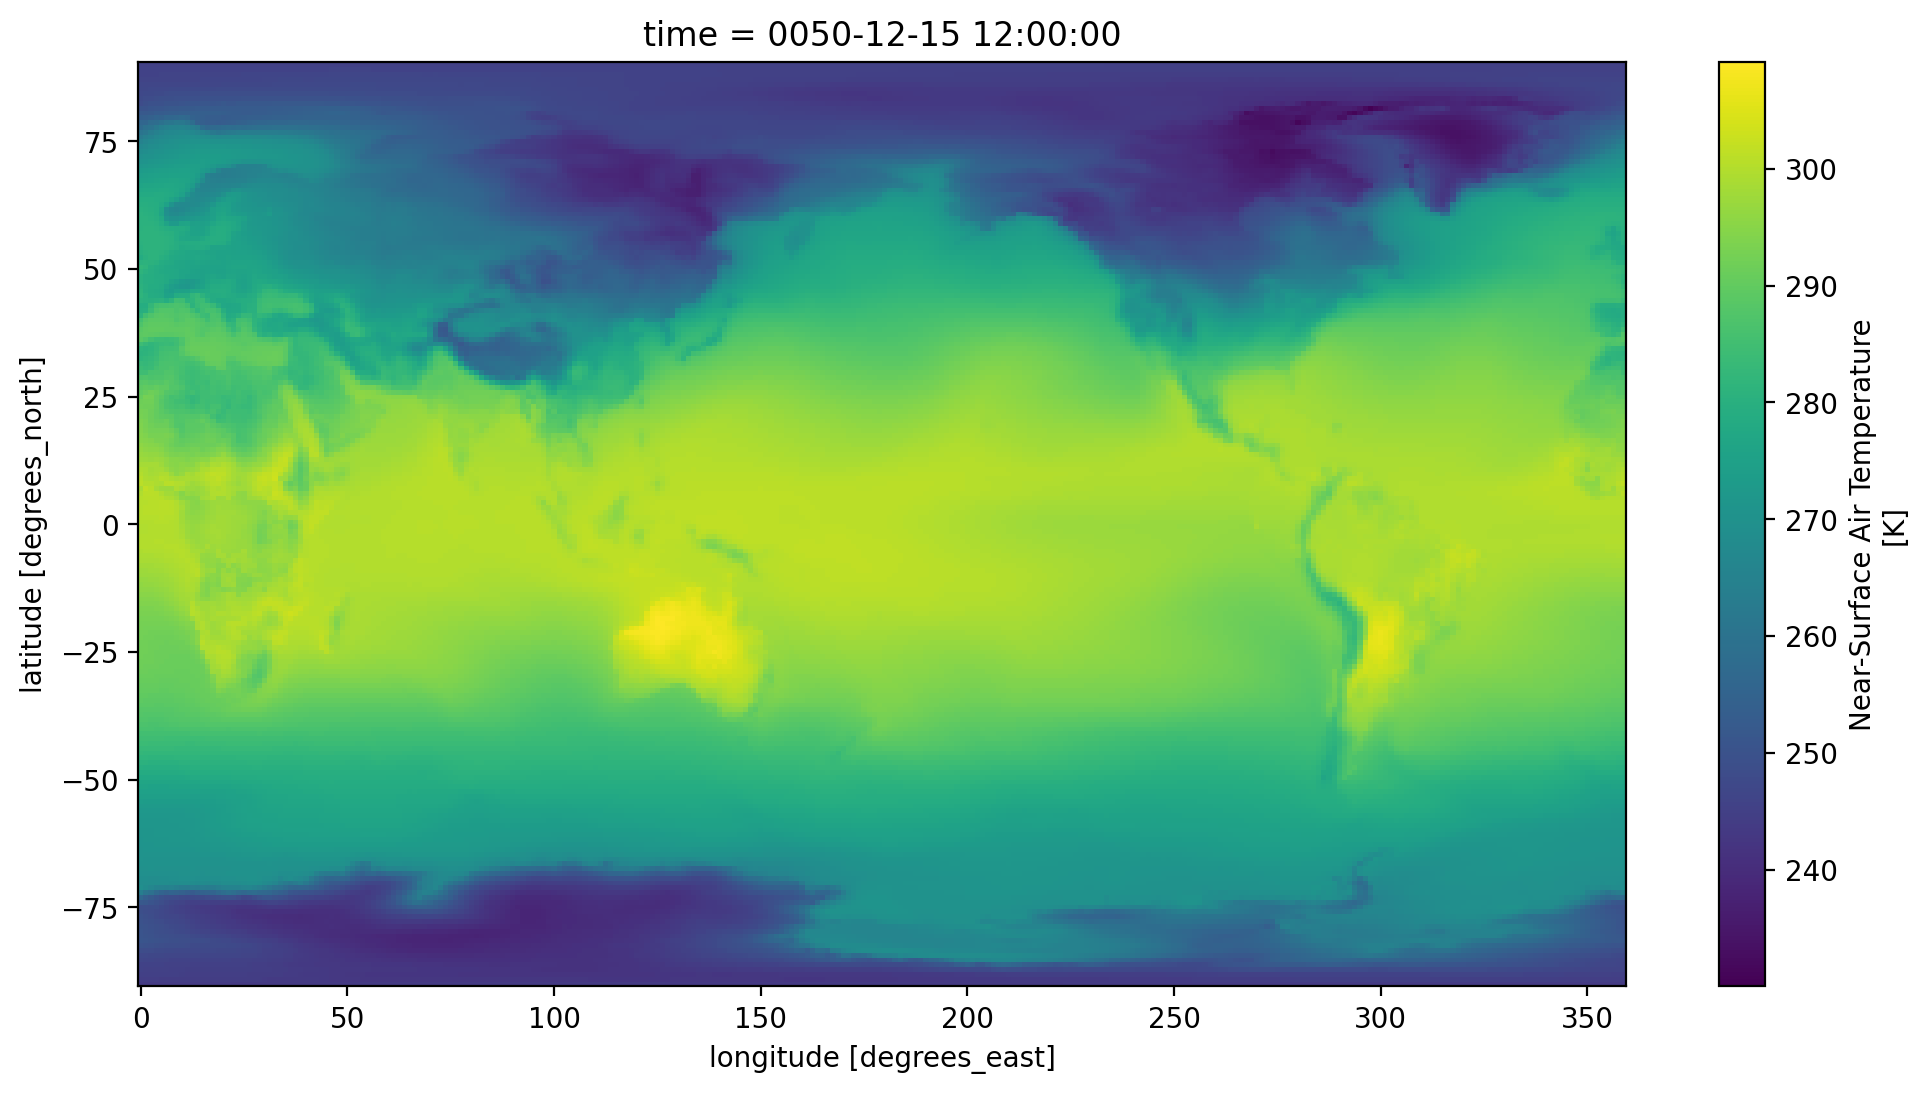

In [ ]:
ds_tas_piC.tas.sel(time='0050-12').squeeze().plot()

In [ ]:
df_tas_ncar_piC = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'esm-piControl'")

zstore_piC = df_tas_ncar_piC.zstore.values[-1]
print(zstore_piC)
mapper_piC = fsspec.get_mapper(zstore_piC)
ds_tas_piC = xr.open_zarr(mapper_piC, consolidated=True)


date_threshold = cftime.DatetimeNoLeap(000, 1, 1)
ds_tas_piC_plt = ds_tas_piC.copy()
# weighted product
tas_timeseries_piC = (ds_tas_piC_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# convert to np array
array_tas_ts = np.array(tas_timeseries_piC)
print(array_tas_ts.mean())

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190723/
287.19836
